In [1]:
%run multilabel_preprocessing.ipynb

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import json
import warnings

warnings.filterwarnings('ignore')

In [3]:
sns.set_theme()

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
def compute_weights_multilabel(y, num_classes=10):
    # Ensure y is a 2D array
    if y.ndim == 1:
        y = y.reshape(-1, 1)
    
    # Count occurrences of each class
    class_counts = np.sum(y, axis=0)
    
    # Compute weights
    weights = np.zeros(num_classes)
    n_samples = len(y)
    
    for i in range(num_classes):
        if class_counts[i] > 0:
            weights[i] = (n_samples / (num_classes * class_counts[i]))
        else:
            weights[i] = 1.0  # or any other strategy for classes with no samples
    
    # Normalize weights
    weights = weights / np.sum(weights) * num_classes
    
    # Create a dictionary mapping class labels to weights
    class_weight_dict = {i: weight for i, weight in enumerate(weights)}
    
    class_weights = torch.FloatTensor(list(class_weight_dict.values())).cuda()

    return class_weights

In [6]:
class_weights = compute_weights_multilabel(y_train)

In [7]:
num_classes = y_train.shape[1]
num_classes

10

In [8]:
class CNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=hidden_dim, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.leaky_relu1 = nn.LeakyReLU(0.02)
        self.drop1 = nn.Dropout(dropout_prob)

        self.conv2 = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.leaky_relu2 = nn.LeakyReLU(0.02)
        self.drop2 = nn.Dropout(dropout_prob)

        self.pool = nn.AdaptiveAvgPool1d(1) 

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.leaky_relu1(out)
        out = self.drop1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.leaky_relu2(out)
        out = self.drop2(out)
        
        out = self.pool(out)
        out = out.view(out.size(0), -1) 
        out = self.fc(out)

        return out

In [9]:
with open('best_params.json', 'r') as f:
    params = json.load(f)

In [10]:
params

{'lr': 0.00015980031033814945,
 'hidden_dim': 512,
 'epochs': 150,
 'weight_decay': 4.1353489916937214e-05,
 'beta1': 0.9793705961099923,
 'beta2': 0.9371777242740655,
 'dropout': 0.3292182748694722}

In [11]:
input_dim = X_train.shape[1]
output_dim = num_classes
dropout_prob = params['dropout']
hidden_dim = params['hidden_dim']

model = CNNModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, dropout_prob=dropout_prob).to(device)

In [12]:
model

CNNModel(
  (conv1): Conv1d(192, 512, kernel_size=(3,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.02)
  (drop1): Dropout(p=0.3292182748694722, inplace=False)
  (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.02)
  (drop2): Dropout(p=0.3292182748694722, inplace=False)
  (pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [13]:
lr = params['lr']
beta1 = params['beta1']
beta2 = params['beta2']
weight_decay = params['weight_decay']

optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, beta2), weight_decay=weight_decay)
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

In [14]:
train_losses = []
test_losses = []
accuracy_values = []

num_epochs = params['epochs']
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_total = 0
    correct = 0
    test_total = 0
    test_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        train_total += labels.size(0)
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()

            correct += (predicted == labels).sum().item()
            test_total += labels.numel()

    train_loss = running_loss / train_total
    test_loss = test_loss / test_total
    accuracy = correct / test_total
    
    # Store losses for plotting
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracy_values.append(accuracy*100)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy*100:.4f}%')

Epoch 1/150, Train Loss: 0.2873, Test Loss: 0.0102, Accuracy: 86.2853%
Epoch 2/150, Train Loss: 0.0761, Test Loss: 0.0069, Accuracy: 86.2994%
Epoch 3/150, Train Loss: 0.0710, Test Loss: 0.0059, Accuracy: 86.5678%
Epoch 4/150, Train Loss: 0.0659, Test Loss: 0.0055, Accuracy: 86.5678%
Epoch 5/150, Train Loss: 0.0614, Test Loss: 0.0054, Accuracy: 86.6102%
Epoch 6/150, Train Loss: 0.0590, Test Loss: 0.0055, Accuracy: 86.6102%
Epoch 7/150, Train Loss: 0.0576, Test Loss: 0.0055, Accuracy: 86.6102%
Epoch 8/150, Train Loss: 0.0561, Test Loss: 0.0055, Accuracy: 86.8644%
Epoch 9/150, Train Loss: 0.0548, Test Loss: 0.0055, Accuracy: 87.1893%
Epoch 10/150, Train Loss: 0.0541, Test Loss: 0.0056, Accuracy: 87.2740%
Epoch 11/150, Train Loss: 0.0529, Test Loss: 0.0054, Accuracy: 87.8955%
Epoch 12/150, Train Loss: 0.0523, Test Loss: 0.0055, Accuracy: 87.7825%
Epoch 13/150, Train Loss: 0.0510, Test Loss: 0.0055, Accuracy: 88.3192%
Epoch 14/150, Train Loss: 0.0504, Test Loss: 0.0055, Accuracy: 88.1638%
E

In [27]:
y_true = []
y_pred = []
correct = 0
test_total = 0

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = (torch.sigmoid(outputs) > 0.5).float()

        correct += (predicted == labels).sum().item()
        test_total += labels.numel()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
    
accuracy = correct / test_total
print(f'Accuracy: {accuracy*100}%')

Accuracy: 95.2683615819209%


In [16]:
precision = precision_score(y_true, y_pred, average='samples')
recall = recall_score(y_true, y_pred, average='samples')
f1 = f1_score(y_true, y_pred, average='samples')

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

Precision: 0.9004, Recall: 0.7740, F1-score: 0.8159


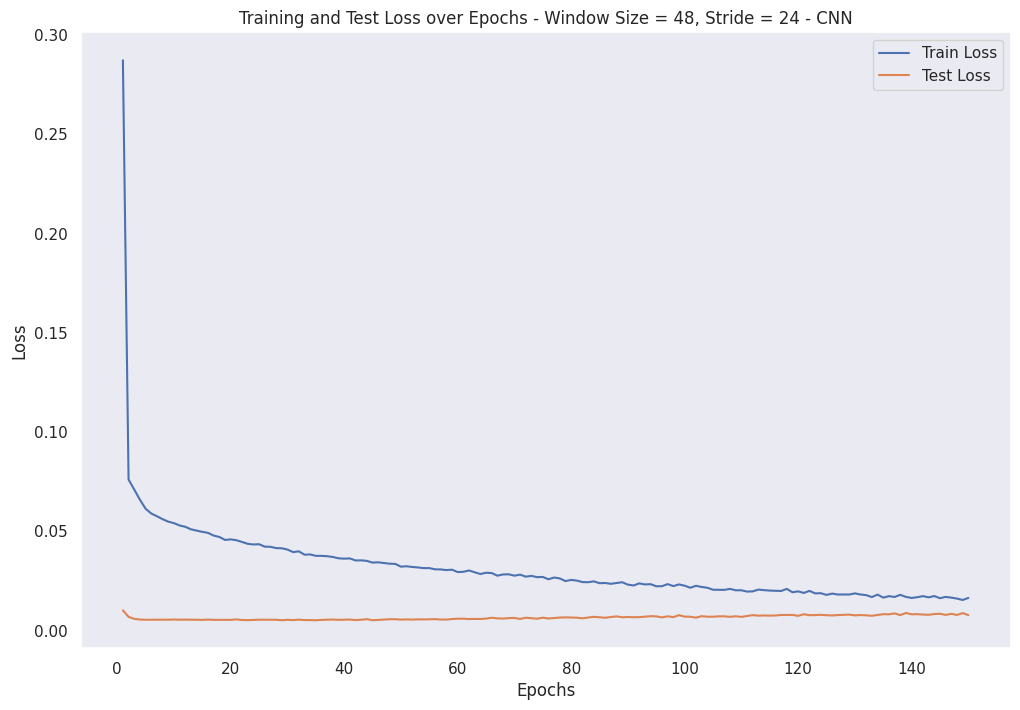

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training and Test Loss over Epochs - Window Size = {window_size}, Stride = {stride} - CNN')
plt.legend()
plt.grid(False)
plt.show()

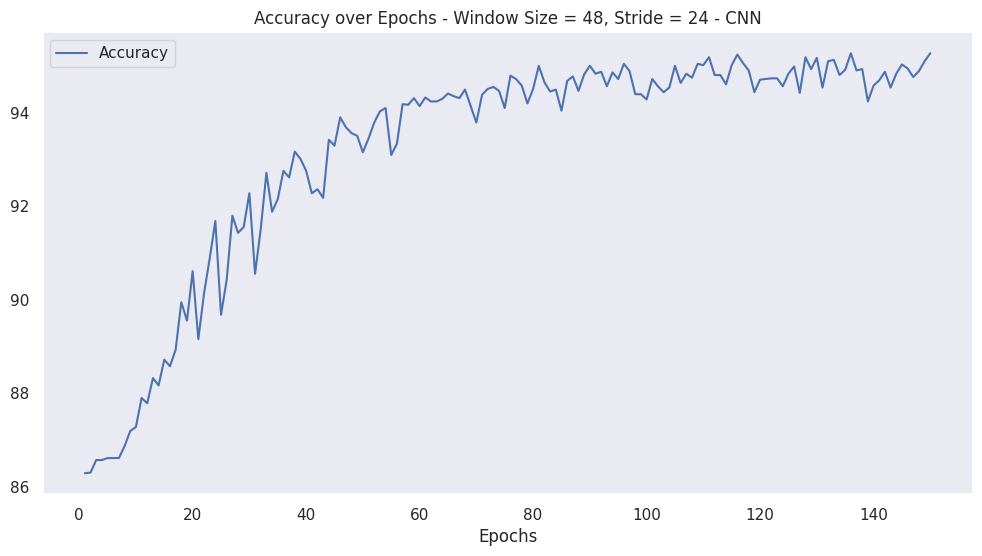

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), accuracy_values, label='Accuracy')
plt.xlabel('Epochs')
plt.title(f'Accuracy over Epochs - Window Size = {window_size}, Stride = {stride} - CNN')
plt.legend()
plt.grid(False)
plt.show()

In [19]:
mcm = multilabel_confusion_matrix(y_true, y_pred)

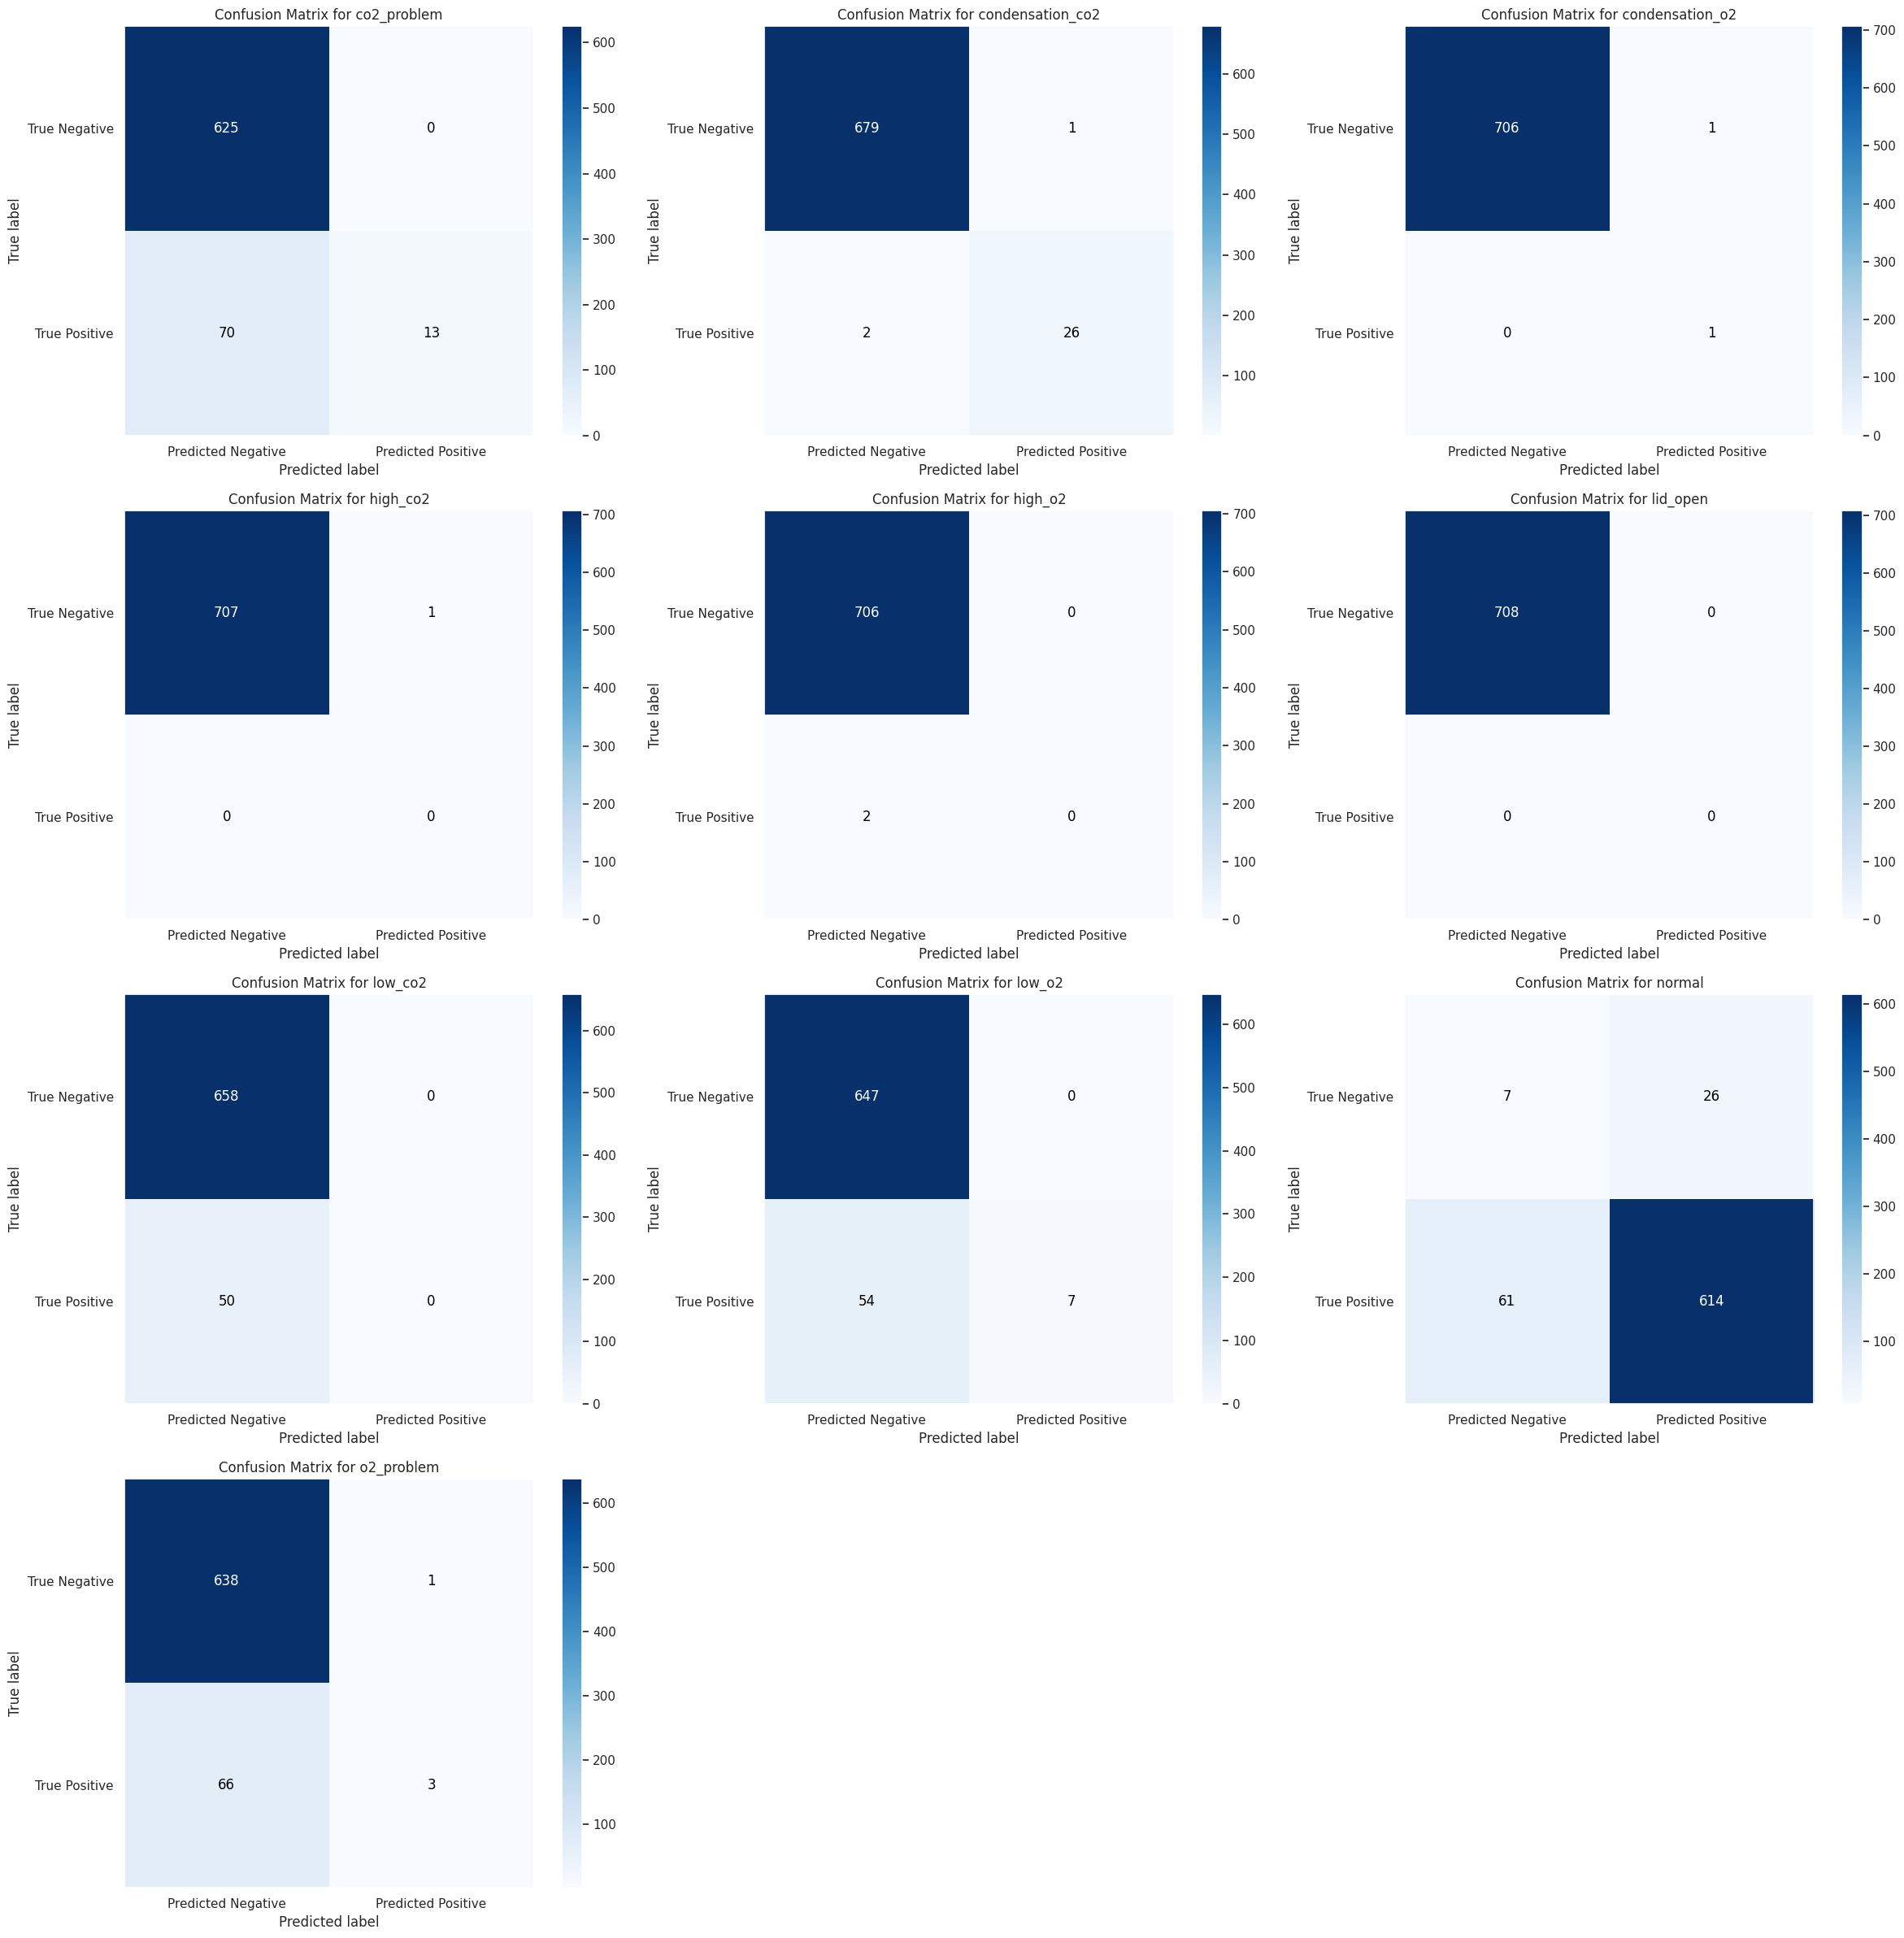

In [33]:
def plot_multilabel_confusion_matrix(mcm, class_names, cols=3):
    n_classes = mcm.shape[0]
    rows = (n_classes + cols - 1) // cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(8 * cols, 6 * rows))
    axes = axes.flatten()  # Flatten in case we have multiple rows
    
    for i, (cm, class_name) in enumerate(zip(mcm, class_names)):
        ax = axes[i]
        
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax)
        
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               xticklabels=['Predicted Negative', 'Predicted Positive'],
               yticklabels=['True Negative', 'True Positive'],
               title=f'Confusion Matrix for {class_name}',
               ylabel='True label',
               xlabel='Predicted label')
        
        # Loop over data dimensions and create text annotations.
        fmt = 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
                ax.grid(False)

    # Remove any unused subplots
    for j in range(len(class_names), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

class_names = labels_df.columns
plot_multilabel_confusion_matrix(mcm, class_names)


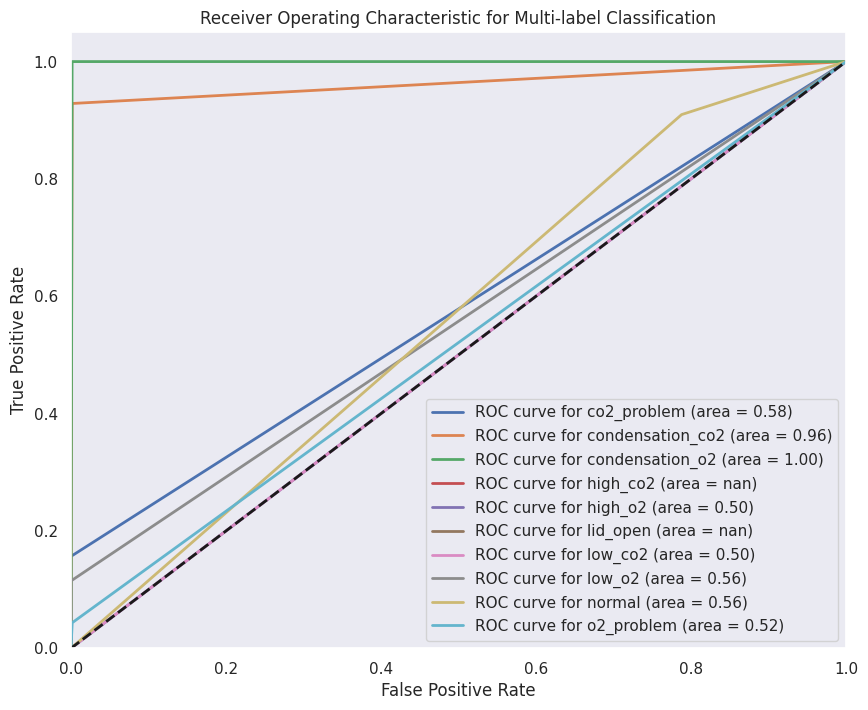

In [30]:
from sklearn.metrics import roc_curve, auc

def plot_multilabel_roc(y_true, y_pred, class_names, n_classes):
    # Convert y_true and y_pred to numpy arrays if they aren't already
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Binarize the output labels if they aren't already binary
    if y_true.ndim == 1 or y_true.shape[1] == 1:
        y_true = label_binarize(y_true, classes=np.arange(n_classes))
    
    # Calculate ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves for each class
    plt.figure(figsize=(10, 8))
    
    for i, class_name in enumerate(class_names):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve for {class_name} (area = {roc_auc[i]:0.2f})')
    
    # Plot a diagonal line for random predictions
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for Multi-label Classification')
    plt.grid(False)
    plt.legend(loc='lower right')
    plt.show()

plot_multilabel_roc(y_test, y_pred, class_names, len(class_names))

In [28]:
model = torch.jit.script(model)
torch.jit.save(model, f'cnn_model_1_{window_size}h_{stride}s.pt')